# ECE 401 MP5: Discrete Fourier Transform

In this file, we're going to use the inverse DFT to create images from MRI spectral measurements.  Then we'll use the DFT to filter out noise in an image.

In [2]:
import os, h5py
import numpy as np
import matplotlib.figure
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
import submitted

## 0. Data

The data are provided for you in the file `data.hdf5`.  Let's load it, and see what it contains.

In [3]:
with h5py.File('data.hdf5','r') as f:
    print('data.hdf5 has the keys',f.keys())
    mri_dft = f['mri_dft'][:]
    image = f['image'][:]
    noisy_image = f['noisy_image'][:]
print('mri_dft is an array of shape',mri_dft.shape,'and dtype',mri_dft.dtype)
print('image is an array of shape',image.shape,'and dtype',image.dtype)
print('noisy_image is an array of shape',noisy_image.shape,'and dtype',noisy_image.dtype)

data.hdf5 has the keys <KeysViewHDF5 ['image', 'mri_dft', 'noisy_image']>
mri_dft is an array of shape (1114, 962) and dtype complex128
image is an array of shape (213, 320, 3) and dtype float64
noisy_image is an array of shape (213, 320, 3) and dtype float64


## 1. MRI

MRI (magnetic resonance images) are acquired in the frequency domain.  It works roughly like this:

1. Every atom in your body spins, all the time, emitting weak radio signals.  A strong magnetic field will align a few percent of them all in the same direction, so that their radio signals can be measured.
2. If the external magnetic field is slightly different in different locations, then the synchronized spin will be at slightly different frequencies in different locations.  By holding this difference for a carefully controlled amount of time, we can set it up so that your atoms are spinning with slightly different phases  in different locations.  The phase at location $(n_1,n_2)$ might be tweaked to be $\phi=-\omega_1n_1-\omega_2n_2$.
3. If the density of hydrogen atoms at location $(n_1,n_2)$ is given by $x[n_1,n_2]$, then the total signal collected is

$$X(\omega_1,\omega_2) = \sum_{n_1}\sum_{n_2} x[n_1,n_2] e^{-j\omega_1 n_1}e^{-j\omega_2 n_2}$$

4. After measuring $X(\omega_1,\omega_2)$ at $N_1$ different values of $\omega_1$, and $N_2$ different values of $\omega_2$, then we compute the inverse DFT in order to calculate the image.

The image you  are provided, `mri_dft`, is a  set of complex-valued frequency samples from a real MRI image (a public domain image from Wikipedia, donated by Johns Hopkins  University).  Let's try taking the inverse DFT, to see if we  can  see the image.


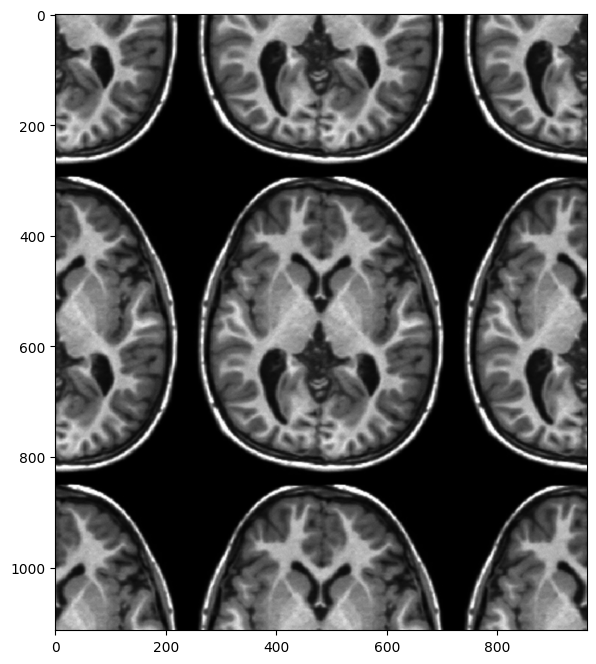

In [4]:
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(np.maximum(0,np.real(np.fft.ifft2(mri_dft))), cmap='gray')


The aliasing we see, here, is caused by capturing only $N_1\times N_2$ frequency samples, but computing the DFT using a spatial range  $M_1\times M_2$ such that $M_1>N_1$ and/or $M_2>N_2$.  By doing that, we accidentally discover that the DFT is periodic in **space**, not just in **frequency**:

$$x[N+n] = \frac{1}{N}\sum_k X[k]e^{j\frac{2\pi k(n+N)}{N}} = \frac{1}{N}\sum_k X[k]e^{j\frac{2\pi kn}{N}} =x[n]$$

In order to solve this problem, we need to figure out how many of the frequency samples in `mri_dft` are actually  nonzero-valued.  To get an idea, let's try plotting the first row:

<StemContainer object of 3 artists>

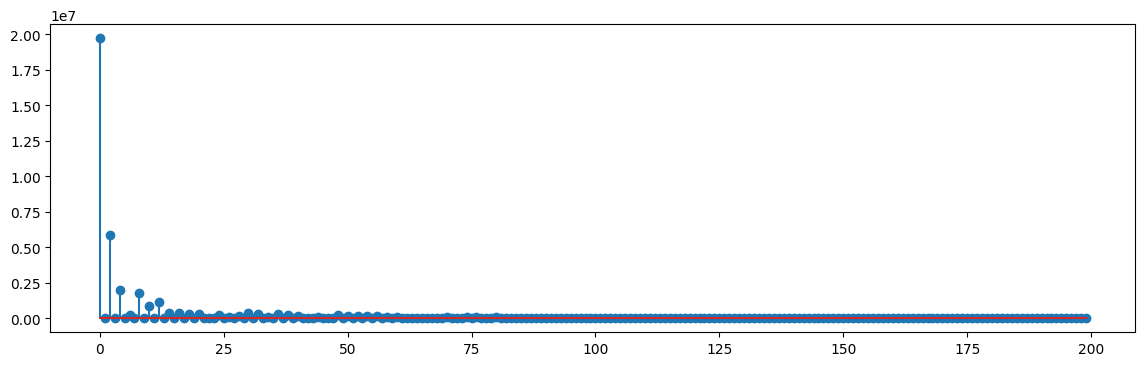

In [5]:
fig, ax = plt.subplots(figsize=(14,4))
ax.stem(np.abs(mri_dft[0,0:200]))

It looks like maybe the odd-numbered spectral samples are zero, and only the even-numbered spectral samples are valid.  Let's try taking the inverse fft of only the even-numbered samples.

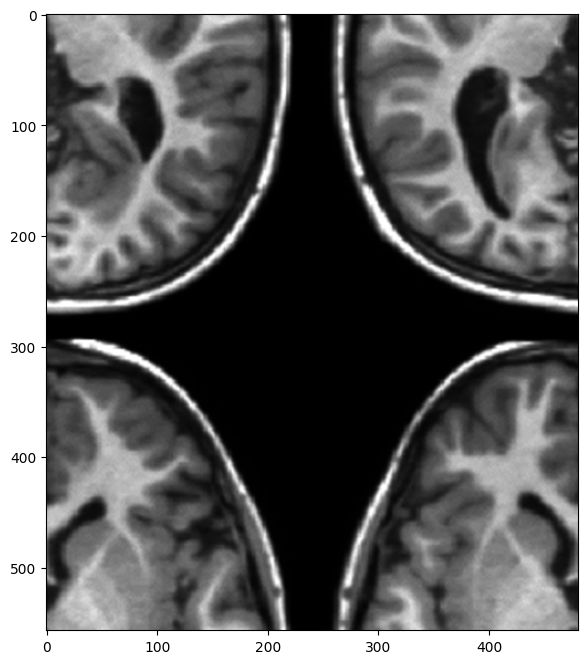

In [6]:
fig,ax = plt.subplots(figsize=(10,8))
downsampling_factor = 2
ax.imshow(np.real(np.fft.ifft2(mri_dft[::downsampling_factor,::downsampling_factor])), cmap='gray')

That's the right size, but now the whole image has been shifted by about $N_1/2$ rows, and  by about  $N_2/2$ columns!  The true image is a circular-shift of the one shown above, i.e., what we want to see is:

$$x_{\text{corrected}}\left[n_1,n_2\right]=
x\left[\langle n_1-\frac{N_1}{2}\rangle_{N_1},
\langle n_2-\frac{N_2}{2}\rangle_{N_2}\right],$$

where $\langle\cdot\rangle_N$ means "modulo $N$."  This shifting is exactly what [np.fft.fftshift](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html) does, except that fftshift does this shifting after we've already taken the inverse DFT.  If we want the inverse FFT to be correct **immediately,** without doing any fftshift, then we have to perform the shift in the frequency domain.  

Remember: shifting is the same as convolving with a shifted impulse.  Convolving in time is the same as multiplying in frequency.

So we can do the `fftshift` operation in the **frequency domain** if we multiply the FFT by the Fourier transform of a shifted impulse:

$$X_{corrected}[k_1,k_2] = 
\begin{cases}
X[k_1,k_2] e^{-j\frac{2\pi k_1d_1}{N_1}}e^{-j\frac{2\pi k_2d_2}{N_2}} & 0\le k_1<\frac{N_1}{2},~0\le k_2<\frac{N_2}{2}\\
X[k_1,k_2] e^{-j\frac{2\pi (k_1-N_1)d_1}{N_1}}e^{-j\frac{2\pi (k_2-N_2)d_2}{N_2}} &\frac{N_1}{2}\le k_1<N_1,~\frac{N_2}{2}\le k_2<N_2
\end{cases}
$$

where $d_1$ is the number of rows that we want to shift, and $d_2$ is the number of columns that we want to shift.
Notice that the second line is actually equal to the first line, in theory (because $e^{-j\frac{2\pi N_1d_1}{N_1}}=1$), but implementing it in the way shown above will help to avoid artifacts caused by floating-point roundoff error.  Notice that the formula above only lists two of the four cases; I think you can figure out what the other two cases should be.

In [7]:
importlib.reload(submitted)
help(submitted.downsample_and_shift_dft2)

Help on function downsample_and_shift_dft2 in module submitted:

downsample_and_shift_dft2(oversampled_dft, downsampling_factor, row_shift, col_shift)
    Input: 
      oversampled_dft [M1,M2] - a 2d array containing the oversampled DFT of a grayscale image
      downsampling_factor (scalar) - the factor by which the DFT image is oversampled
      row_shift (scalar)  - the number of rows that the image should be shifted
      col_shift (scalar) - the number of columns that the image should be shifted
    Output: 
      image [M1/downsampling_factor, M2/downsampling_factor] - the real part of the inverse DFT
      of the valid frequency samples, shifted by the specified numbers of rows and columns.



The original MRI_DFT shape is 1114 962
The downsampled image has shape (557, 481)


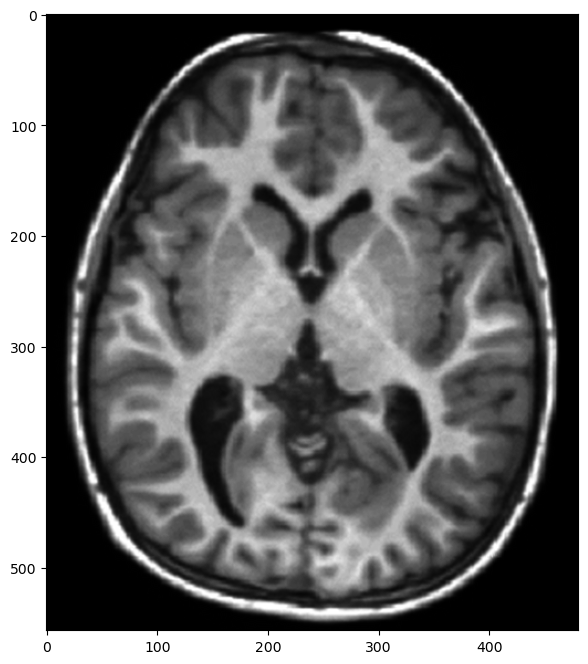

In [8]:
importlib.reload(submitted)
N1, N2 = mri_dft.shape
print('The original MRI_DFT shape is',N1,N2)
image = submitted.downsample_and_shift_dft2(mri_dft,2,N1/4,N2/4)
print('The downsampled image has shape', image.shape)
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(np.maximum(0,np.minimum(255,image)),cmap='gray')

## 2. Noisy Image

Filtering out noise is easier in the time domain, if the noise is wideband noise (meaning that there is noise in a wide range of frequencies).  Sometimes, though, the noise is in a narrow range of frequencies.  For example, consider this image (this is the image "Clifton Beach 5, South Arm, Tasmania, Australia" by JJ Harrison, distributed on Wikimedia under Gnu Free Documentation License):

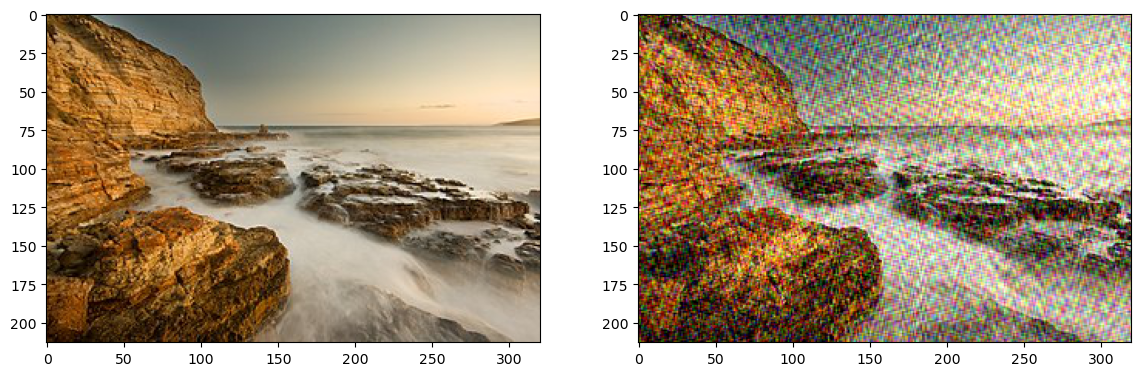

In [9]:
with h5py.File('data.hdf5','r') as f:
    image = f['image'][:]
    noisy_image = f['noisy_image'][:]
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(image)
ax[1].imshow(noisy_image)


You can see that the noisy image has been corrupted with some type of random stripes.  Let's see what the DFT looks like.

Normally, it might be hard to figure out where the noise is.  Since we have the original image, though, we can calculate the noise in each FFT bin.

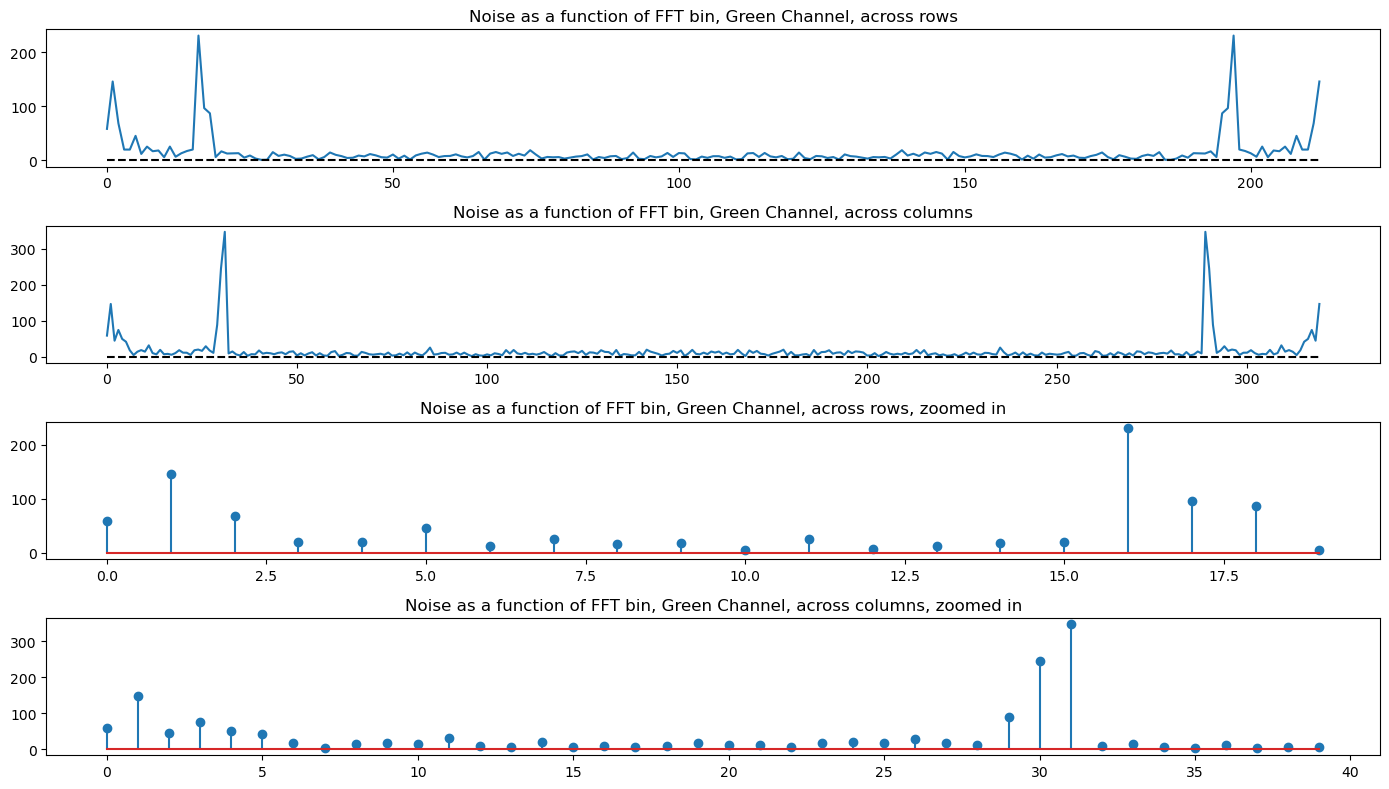

In [10]:
fig, axs = plt.subplots(4,1,figsize=(14,8))
image_dft = np.fft.fft2(image,axes=(0,1))
noisy_dft = np.fft.fft2(noisy_image, axes=(0,1))
noise = noisy_dft - image_dft
M,N,K = noisy_dft.shape

axs[0].plot(np.abs(noise[:,0,1]))
axs[0].plot(np.arange(M),np.zeros(M),'k--')
axs[0].set_title('Noise as a function of FFT bin, Green Channel, across rows')

axs[1].plot(np.abs(noise[0,:,1]))
axs[1].plot(np.arange(N),np.zeros(N),'k--')
axs[1].set_title('Noise as a function of FFT bin, Green Channel, across columns')

axs[2].stem(np.abs(noise[:20,0,1]))
axs[2].set_title('Noise as a function of FFT bin, Green Channel, across rows, zoomed in')

axs[3].stem(np.abs(noise[0,:40,1]))
axs[3].set_title('Noise as a function of FFT bin, Green Channel, across columns, zoomed in')
fig.tight_layout()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(213, 320, 3)


Text(0.5, 1.0, 'Spatial Magnitude DFT of the Noise (noisy_image - image)')

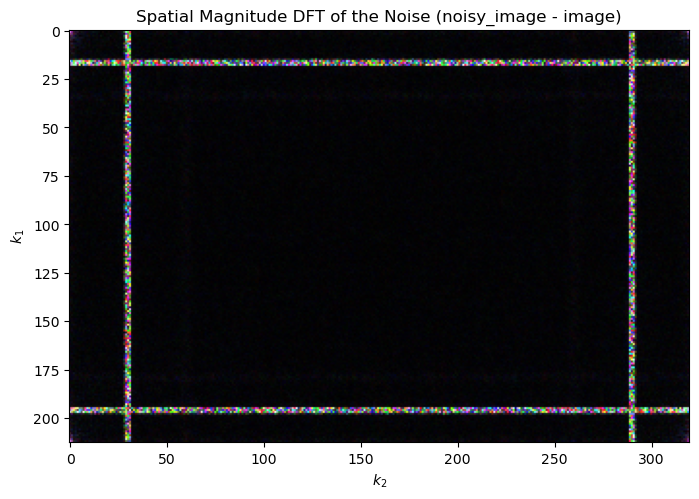

In [11]:
fig, axs = plt.subplots(figsize=(8,6))
print(noise.shape)
axs.imshow(np.abs(noise).astype('int'))
axs.set_xlabel('$k_2$')
axs.set_ylabel('$k_1$')
axs.set_title('Spatial Magnitude DFT of the Noise (noisy_image - image)')

It looks like the noise is mostly in the bands $16\le k_1< 19$, $N_1-19<k_1\le N_1-16$, $29\le k_2<32$, and $N_2-32<k_2\le N_2-29$.

We could get rid of this noise by using an ideal bandstop filter, as in MP4.  Instead, this time, let's try to get rid of it using the DFT.

Let's try to get rid of the noise by just zeroing out those channels.  Implement the `dft_filter` function, with the following description:

$$X_{\mbox{corrected}}[k_1,k_2]=\begin{cases}
0 & \mbox{min}_1\le (k_1~\mbox{or}~N_1-k_1)<\mbox{max}_1\\
0 & \mbox{min}_2\le (k_2~\mbox{or}~N_2-k_2)<\mbox{max}_2\\
X[k_1,k_2] & \mbox{otherwise}
\end{cases}
$$

where $\mbox{min}_1$, $\mbox{max}_1$, $\mbox{min}_2$, and $\mbox{max}_2$ are band edges.  

This is the same as finding $Y[k]=H[k]X[k]$ where 

$$H[k_1,k_2]=\begin{cases}
0 & \mbox{min}_1\le (k_1~\mbox{or}~N_1-k_1)<\mbox{max}_1\\
0 & \mbox{min}_2\le (k_2~\mbox{or}~N_2-k_2)<\mbox{max}_2\\
1 & \mbox{otherwise}
\end{cases}
$$


In [12]:
importlib.reload(submitted)
help(submitted.dft_filter)

Help on function dft_filter in module submitted:

dft_filter(noisy_image, min1, max1, min2, max2)
    Input: 
      noisy_image [N1,N2] - an image with narrowband noises
      min1, max1 (scalars) - zero out all rows of the DFT min1 <= k1 < max1, likewise  for N1-k1
      min2, max2 (scalars) - zero out all cols  of the DFT min2 <= k2 < max2, likewise for N2-k2
    Outut:
      cleaned_image [N1,N2] - image with the corrupted bands removed.
      Be sure to take the real part of the inverse DFT, and then truncate
      so that 0 <= cleaned_image[n1,n2,color] <= 1 for all n1,n2,color.



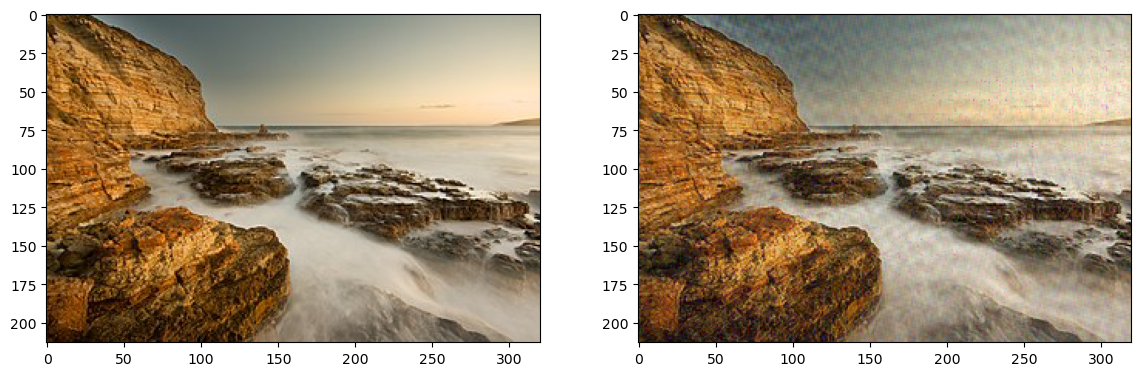

In [13]:
importlib.reload(submitted)
cleaned_image = submitted.dft_filter(noisy_image,16,19,29,32)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(image)
ax[1].imshow(cleaned_image)


## 3. Transition Band

As shown above, the band-stop denoising filter gets rid of some of the noise, but not all of it.  There seems like there might be some ripple artifact.

Remember that, when we were using ideal filters, similar ripple artifacts were caused by truncating the impulse response using  a rectangular window.  The way we avoided ripple artifacts then was by using a  Hamming window instead.

One important difference between a Hamming window and a rectangular window is that the Hamming window has a wider transition band.  So let's introduce a transition band into our filter:

$$X_{\mbox{corrected}}[k_1,k_2]=\begin{cases}
0 & \mbox{min}_1\le (k_1~\mbox{or}~N_1-k_1)<\mbox{max}_1\\
0 & \mbox{min}_2\le (k_2~\mbox{or}~N_2-k_2)<\mbox{max}_2\\
\frac{1}{2}X[k_1,k_2] & k_1\in\left\{\mbox{min}_1-1,\mbox{max}_1\right\}\\
\frac{1}{2}X[k_1,k_2] & k_2\in\left\{\mbox{min}_2-1,\mbox{max}_2\right\}\\
\frac{1}{2}X[k_1,k_2] & N_1-k_1\in\left\{\mbox{min}_1-1,\mbox{max}_1\right\}\\
\frac{1}{2}X[k_1,k_2] & N_2-k_2\in\left\{\mbox{min}_2-1,\mbox{max}_2\right\}\\
X[k_1,k_2] & \mbox{otherwise}
\end{cases}
$$

This is the same as finding $Y[k]=H[k]X[k]$ where 

$$H[k_1,k_2]=\begin{cases}
0 & \mbox{min}_1\le (k_1~\mbox{or}~N_1-k_1)<\mbox{max}_1\\
0 & \mbox{min}_2\le (k_2~\mbox{or}~N_2-k_2)<\mbox{max}_2\\
\frac{1}{2} & k_1\in\left\{\mbox{min}_1-1,\mbox{max}_1\right\}\\
\frac{1}{2} & k_2\in\left\{\mbox{min}_2-1,\mbox{max}_2\right\}\\
\frac{1}{2} & N_1-k_1\in\left\{\mbox{min}_1-1,\mbox{max}_1\right\}\\
\frac{1}{2} & N_2-k_2\in\left\{\mbox{min}_2-1,\mbox{max}_2\right\}\\
1 & \mbox{otherwise}
\end{cases}
$$

In [14]:
importlib.reload(submitted)
help(submitted.transitioned_filter)

Help on function transitioned_filter in module submitted:

transitioned_filter(noisy_image, min1, max1, min2, max2)
    Input: 
      noisy_image [N1,N2] - an image with narrowband noises
      min1, max1 (scalars) - zero out all rows of the DFT min1 <= k1 < max1, likewise  for N1-k1
      min2, max2 (scalars) - zero out all cols  of the DFT min2 <= k2 < max2, likewise for N2-k2
    Outut:
      cleaned_image [N1,N2] - image with the corrupted bands removed.
      Be sure to take the real part of the inverse DFT, and then truncate
      so that 0 <= cleaned_image[n1,n2,color] <= 1 for all n1,n2,color.
    
    Transition band:
      the bands k1=min1-1, k1=max1, k2=min2-1, and k2=max2 should be set to half of their
      original values, 0.5*X[k1,k2].



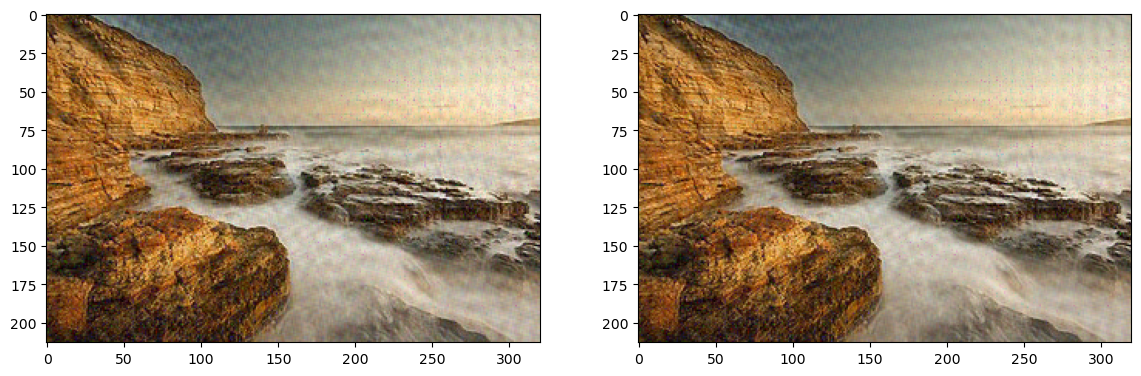

In [15]:
importlib.reload(submitted)
transitioned_image = submitted.transitioned_filter(noisy_image,16,19,29,32)
fig, ax = plt.subplots(1,2,figsize=(14,10))
ax[0].imshow(cleaned_image)
ax[1].imshow(transitioned_image)


TBH, it's a little hard to tell which cleaned-up image is best.  Well, at least we learned how to make a transition band in DFT-based filtering!

## 4. Overlap-Add

Now let's try using overlap-add to filter a very long audio.

First, we need to zero-pad the input and the filter.  Suppose you have:
* $h[n]$ has a length of $L$
* $x[n]$ has a length of $M$

Then the function zero-pad should return $h[n]$ and $x[n]$, both zero-padded to $N=L+M-1$ samples.

In [16]:
importlib.reload(submitted)
help(submitted.zero_pad)

Help on function zero_pad in module submitted:

zero_pad(h, x)
    (hp,xp) = zero_pad(h,x)
    Input:
      h [L] - a length-L impulse response array
      x [M] - a length-M signal array
    Return: 
      hp [N] - the same h, but zero-padded to a length of N=L+M-1
      xp [N] - the same x, but zero-padded to a length of N=L+M-1



Let's create a lowpass filter for $h[n]$, with a cutoff of $0.075\pi$ radians/sample, and let's say a length of 256 samples.  For $x[n]$, let's just add two sine waves, one with a frequency of $0.05\pi$, one with a frequency of $0.1\pi$.

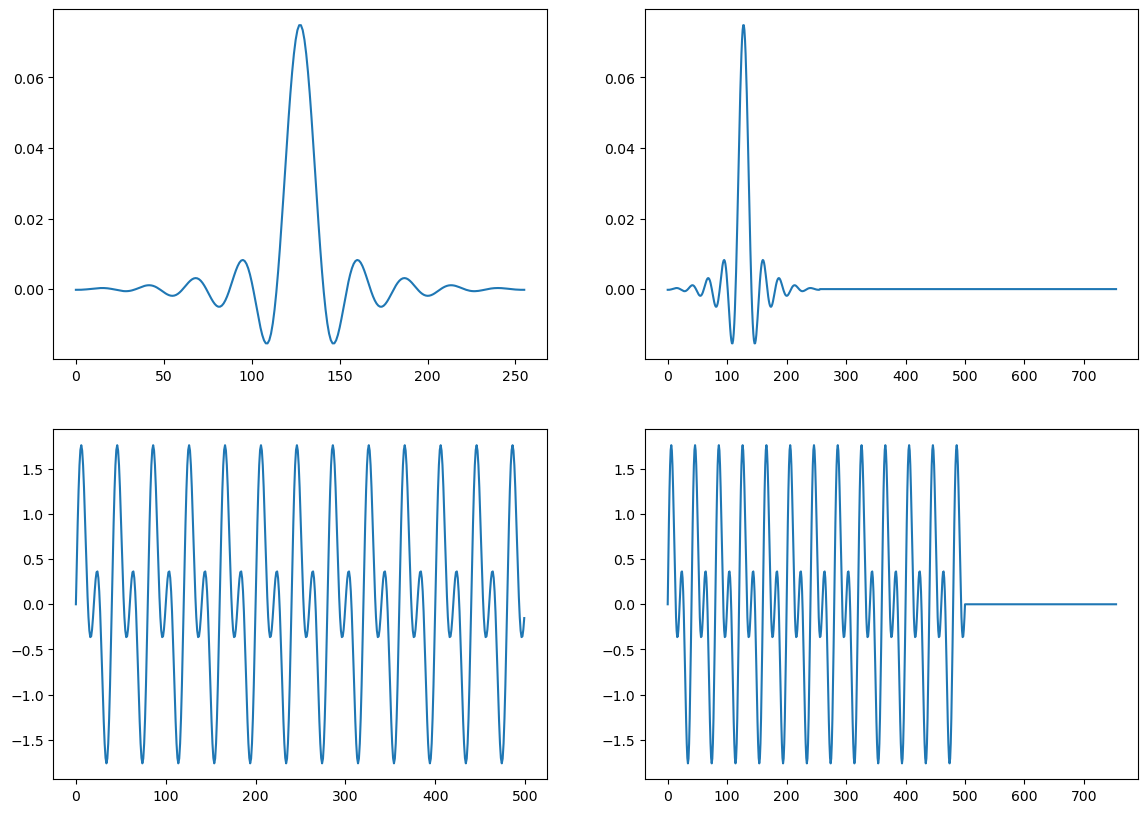

In [17]:
h = 0.075*np.sinc(0.075*(np.arange(256)-127.5)) * np.hamming(256)
x = np.sin(0.05*np.pi*np.arange(500))+np.sin(0.1*np.pi*np.arange(500))
hp, xp = submitted.zero_pad(h,x)
fig, ax = plt.subplots(2,2,figsize=(14,10))
ax[0,0].plot(h)
ax[0,1].plot(hp)
ax[1,0].plot(x)
ax[1,1].plot(xp)

Now let's try multiplying their FFTs.  The resulting $y[n]$ should still contain the sine wave at $0.05\pi$, but the sine wave at $0.1\pi$ should be mostly filtered out.

Text(0.5, 1.0, 'Result of x[n]*h[n]')

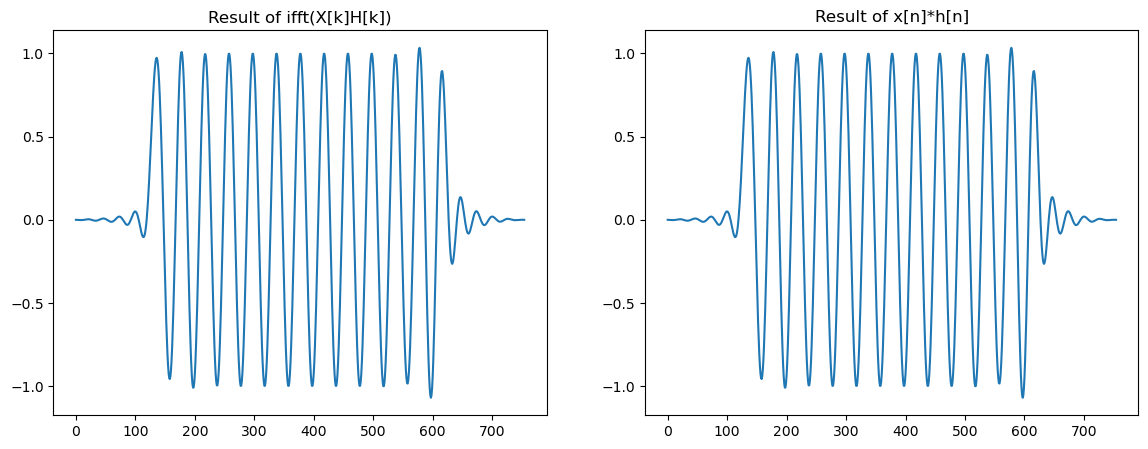

In [18]:
X = np.fft.fft(xp)
H = np.fft.fft(hp)
Y = X*H
y = np.real(np.fft.ifft(Y))
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(y)
ax[0].set_title('Result of ifft(X[k]H[k])')
ax[1].plot(np.convolve(x,h))
ax[1].set_title('Result of x[n]*h[n]')

Let's download an audio file, add some noise to it, and then try to filter the worst of the noise out.

In [19]:
import urllib.request
example_url = "https://catalog.ldc.upenn.edu/desc/addenda/LDC93S1.wav"
webdata = urllib.request.urlopen(example_url).read()
f1 = open("webdata.wav", "wb")
f1.write(webdata)
f1.close()

Go ahead and listen to the file `webdata.wav` if you want to.  If you don't already have soundfile installed (it doesn't exist in `requirements.txt`, because it's not necessary for the autograder), you might now want to install it by running the following block:


In [20]:
!pip install soundfile

Now we can load the sound file and listen to it:

In [21]:
import soundfile as sf
speech_wave, speech_rate = sf.read("webdata.wav")
import IPython
IPython.display.Audio(data=speech_wave, rate=speech_rate)

Let's add noise.  Let's make the noise power exactly the same as the sound power.  If we call the signal $s[n]$ and the noise $v[n]$, then we want:

$$\frac{1}{N}\sum_{n=0}^{N-1} s^2[n]=\frac{1}{N}\sum_{n=0}^{N-1} v^2[n]$$

We can do this by generating a zero-mean unit-variance Gaussian random signal, using the method [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html), and then scaling it by the square root of the signal power.

When the noise and the signal have the same power, we say that the signal-to-noise ratio (SNR) is 0dB (zero decibels).  That's because the **level** of any ratio (e.g., of the signal-to-noise ratio), when measured in decibels, is 10 times the logarithm of the ratio:

$$\text{SNR}\left[\text{dB}\right] = 10\log_{10}\frac{\frac{1}{N}\sum_{n=0}^{N-1} s^2[n]}{\frac{1}{N}\sum_{n=0}^{N-1} v^2[n]}$$

If you plug the top formula into the bottom formula, you discover that the SNR of our new noisy audio signal will be $10\log_{10}(1)=0$dB.

In [22]:
import numpy as np
speech_power = np.average(np.square(speech_wave))
noisy_speech = speech_wave + np.sqrt(speech_power)*np.random.randn(len(speech_wave))
IPython.display.Audio(data=noisy_speech,rate=speech_rate)

Let's plot the SNR as a function of frequency, to see which frequencies we should keep.

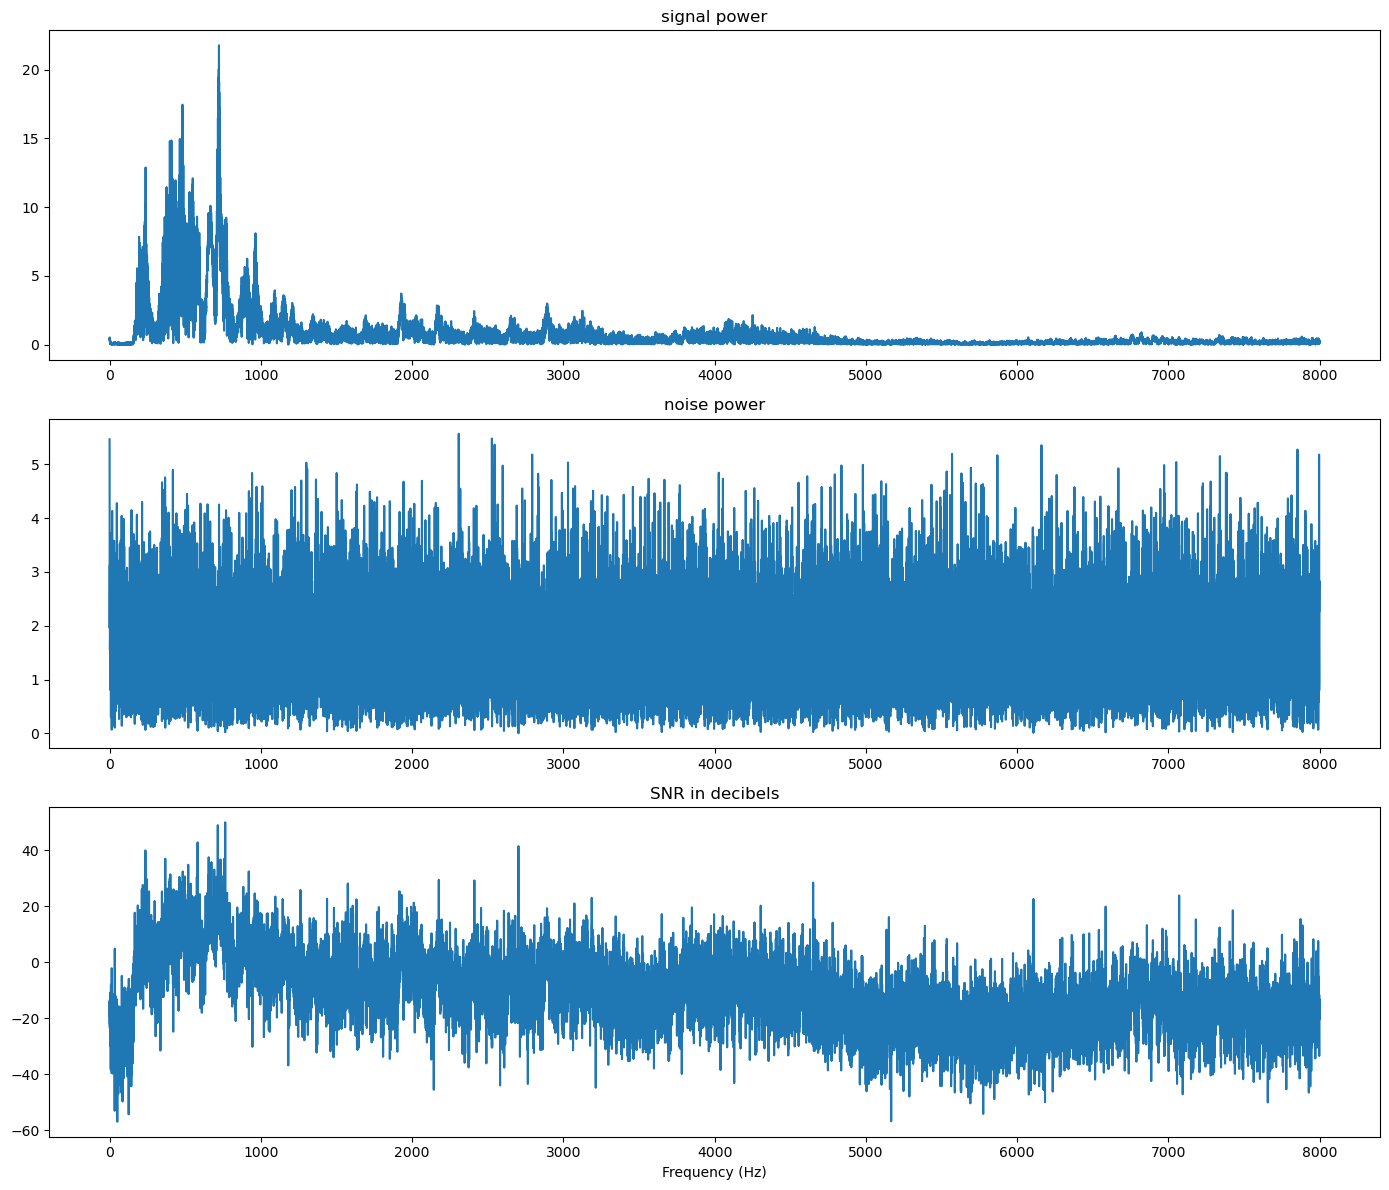

In [23]:
import matplotlib.pyplot as plt

N = len(noisy_speech)
noise = noisy_speech - speech_wave
noise_dft = np.fft.fft(noise)
speech_dft = np.fft.fft(speech_wave)
SNR = 20*np.log10(np.abs(speech_dft)/np.abs(noise_dft))
frequency_axis = np.linspace(0,speech_rate,N)

fig, ax = plt.subplots(3,1,figsize=(14,12))
ax[0].plot(frequency_axis[:int(N/2)],np.abs(speech_dft[:int(N/2)]))
ax[0].set_title('signal power')
ax[1].plot(frequency_axis[:int(N/2)], np.abs(noise_dft[:int(N/2)]))
ax[1].set_title('noise power')
ax[2].plot(frequency_axis[:int(N/2)], SNR[:int(N/2)])
ax[2].set_title('SNR in decibels')
ax[2].set_xlabel('Frequency (Hz)')
fig.tight_layout()

It looks like the SNR drops to about 0dB somewhere near 3200Hz, so let's create a LPF at that frequency, and try filtering the speech using `np.convolve`.  

The sampling rate is $F_s=16000$samples/second, so a cutoff frequency of 3200Hz corresponds to $2\pi\left(\frac{3200}{16000}\right)=0.4\pi$ radians/sample.

In order to make the filter really good, let's give it a long impulse response, say, $L=2048$ samples.

Since the speech waveform is so long, that might take a long time, so we'll use `time.time()` to time the operations.

In [24]:
h =0.4*np.sinc(0.4*(np.arange(2048)-1023.5)) * np.hamming(2048)
import time
start_time = time.time()
y_using_convolution = np.convolve(noisy_speech,h)
end_time = time.time()
print('That took', end_time-start_time, 'seconds')
IPython.display.Audio(data=y_using_convolution,rate=speech_rate)

That took 0.014723062515258789 seconds


Not too bad, but we can make it faster using overlap-add.

In [25]:
import importlib
importlib.reload(submitted)
help(submitted.overlap_add)

Help on function overlap_add in module submitted:

overlap_add(h, x, M)
    y = overlap_add(h, x, M)
    Input:
      h [L] - a length-L impulse response array
      x - a very long array containing the signal x
      M (scalar) - the length of frames into which x should be chopped
    Output:
      y - the result of filtering x by h using overlap-add
    
    First, zero-pad h to a length of N samples, where N=L+M-1.
    Second, compute its DFT, H.
    Third, chop x into frames of length M.  
      There should be NF of these; the last one might have fewer than M samples.
    Fourth, prepare the output array, y, of length equal to NF*M + L - 1.
    Fifth, for each frame of M samples in x:
     - zero-pad to a length of N
     - compute its DFT
     - multiply its DFT by H
     - inverse DFT
     - add the inverse DFT to the correct place in the y array
    Return y



In order to make the FFT as efficient as possible, let's set $M=L+1$, so that $M+L-1$ is a power of 2.

In [26]:
importlib.reload(submitted)
M = len(h)+1
start_time = time.time()
y_overlap_add = submitted.overlap_add(h, noisy_speech, M)
end_time = time.time()
print('That took',end_time-start_time,'seconds')
IPython.display.Audio(data=y_overlap_add,rate=speech_rate)

That took 0.005684852600097656 seconds


If you have done this correctly, the two versions of y should be identical, except that `y_overlap_add` may be longer:

In [27]:
print('The average error is',np.average(np.abs(y_overlap_add[:len(y_using_convolution)]-y_using_convolution)))

The average error is 2.679937256729359e-18


## Extra Credit: Wiener Filter

Now you've seen how to use a lowpass filter to get rid of some audio noise.  The question naturally arises: what kind of filter can we use in order to get rid of as much noise as possible?

This question was solved by Norbert Wiener in a series of papers in the first few decades 
of the twentieth century.  He posed it as follows.  Suppose we use $S$ to mean $S(\omega)$.  Suppose we use "$\approx$" to mean "on average," so, for example, a zero-mean random variable could have $S\approx 0$ but $|S|^2\not\approx 0$.  Wiener proposed:

* The clean signal, $S$, is a zero-mean random variable ($S\approx 0$).
* The background noise, $V$, is another zero-mean random variable ($V\approx 0$).  
* The signal and noise are independent: $SV\approx 0$.

Now we want to design a filter, $h[n]$, so that $y[n]=h[n]\ast (s[n]+v[n])$ is as close as possible to $s[n]$.  In the frequency domain, $Y=H(S+V)$, so we want to minimize

$$\text{MSE}=\left|H(S+V)-S\right|^2$$

On average, all the cross-terms between $S$ and $V$ cancel out, so we get

$$\text{MSE}\approx
|H|^2(|S|^2+|V|^2)-2H|S|^2+|S|^2$$


By differentiating, and setting $\frac{d\text{MSE}}{dH}=0$, we get the result that the mean squared error between $Y$ and $S$ is minimized by the following filter:

$$H=\frac{|S|^2}{|S|^2+|V|^2}$$




The key steps in creating a Wiener filter, in order to optimally minimize the noise in your signal, are:

1. Estimate $|S|^2$ and $|V|^2$
1. Compute $H$
1. Inverse FFT to find the impulse response

### Estimating $|S|^2$ and $|V|^2$

In the real world, if you're trying to clean a signal, you don't know in advance what the cleaned signal should sound like, so $|S|^2$ needs to be estimated using some type of model.  In this laboratory exercise, however, we do know, so we might as well use that knowledge. We can estimate $|S|^2$ and $|V|^2$ using a method called Bartlett's periodogram or sometimes just [Bartlett's method](https://en.wikipedia.org/wiki/Bartlett%27s_method):

1. Decide how long you want the impulse response, $h$, to be.  Call that length $L$.
1. Chop the signal $s[n]$ up into $K$ non-overlapping frames.
1. Take their FFT: let $S_k(\omega)$ be the FFT of samples $s[kL]$ through $s[(k+1)L-1]$.
1. Average the squared FFTs to estimate $|S|^2$:

$$|S|^2 = \frac{1}{K}\sum_{k=0}^{K-1}\left|S_k(\omega)\right|^2$$

Write a function called `bartlett_periodogram` to do this task:

In [28]:
import extra, importlib
importlib.reload(extra)
help(extra.bartlett_periodogram)

Help on function bartlett_periodogram in module extra:

bartlett_periodogram(x, K, L)
    Input: 
    x (real array) = signal
    K (int) = number of frames
    L (int) = length of each frame
    Output: 
    Xsq (real array) = average squared magnitude FFT



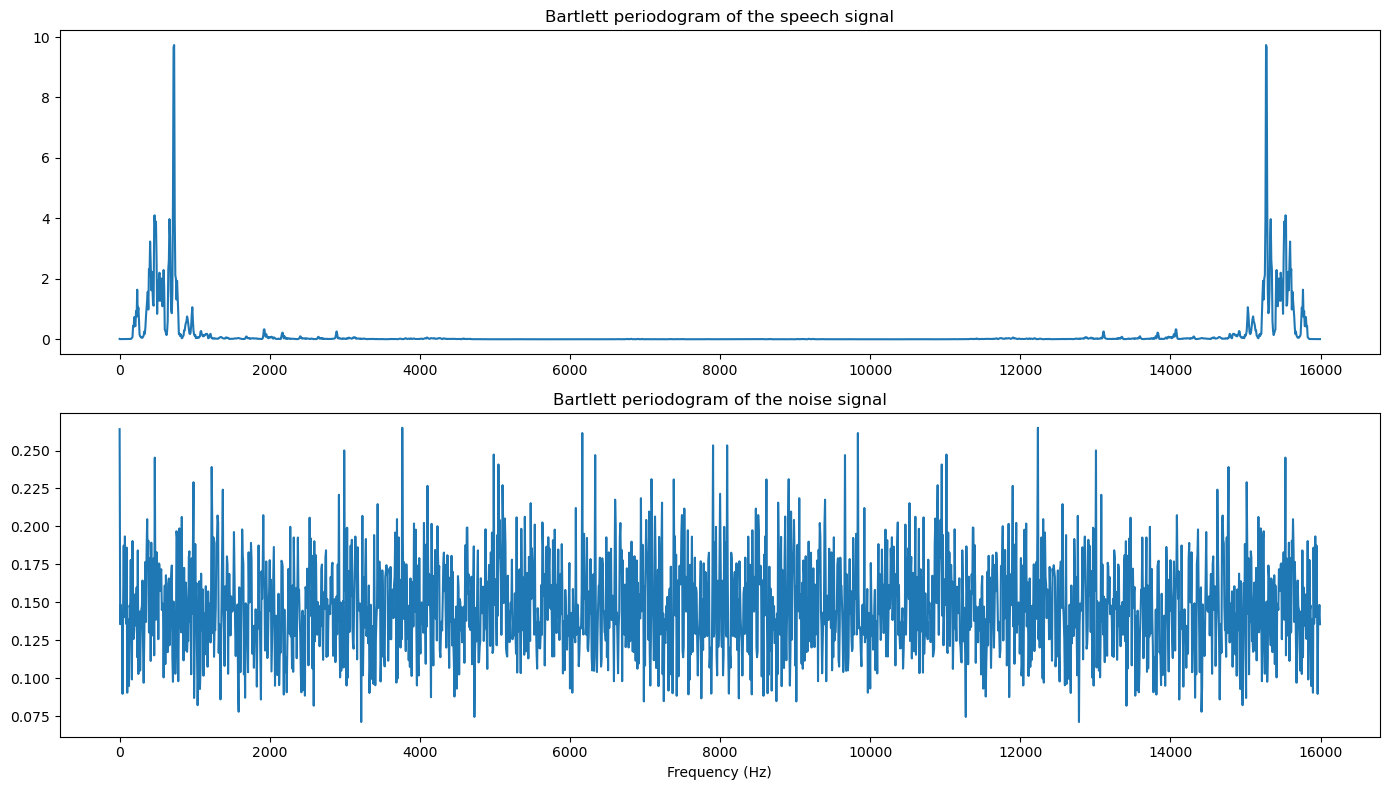

In [29]:
L = 2048
K = 22
importlib.reload(extra)
Ssq = extra.bartlett_periodogram(speech_wave,K,L)
Vsq = extra.bartlett_periodogram(noise,K,L)
frequency_axis = np.linspace(0,speech_rate,L,endpoint=False)

fig, ax = plt.subplots(2,1,figsize=(14,8))
ax[0].plot(frequency_axis,Ssq)
ax[0].set_title('Bartlett periodogram of the speech signal')
ax[1].plot(frequency_axis,Vsq)
ax[1].set_title('Bartlett periodogram of the noise signal')
ax[1].set_xlabel('Frequency (Hz)')
fig.tight_layout()

### Computing $H$ and $h$

Now you just need to compute the frequency response and impulse response of the Wiener filter:

In [30]:
importlib.reload(extra)
help(extra.wiener_filter)

Help on function wiener_filter in module extra:

wiener_filter(Ssq, Vsq)
    Input: 
    Ssq (real array, length L) = average squared magnitude FFT of the signal
    Vsq (real array, length L) = average squared magnitude FFT of the noise
    Output: 
    H (real array, length L) = frequency response of the Wiener filter
    h (real array, length L) = fftshifted impulse response of the Wiener filter



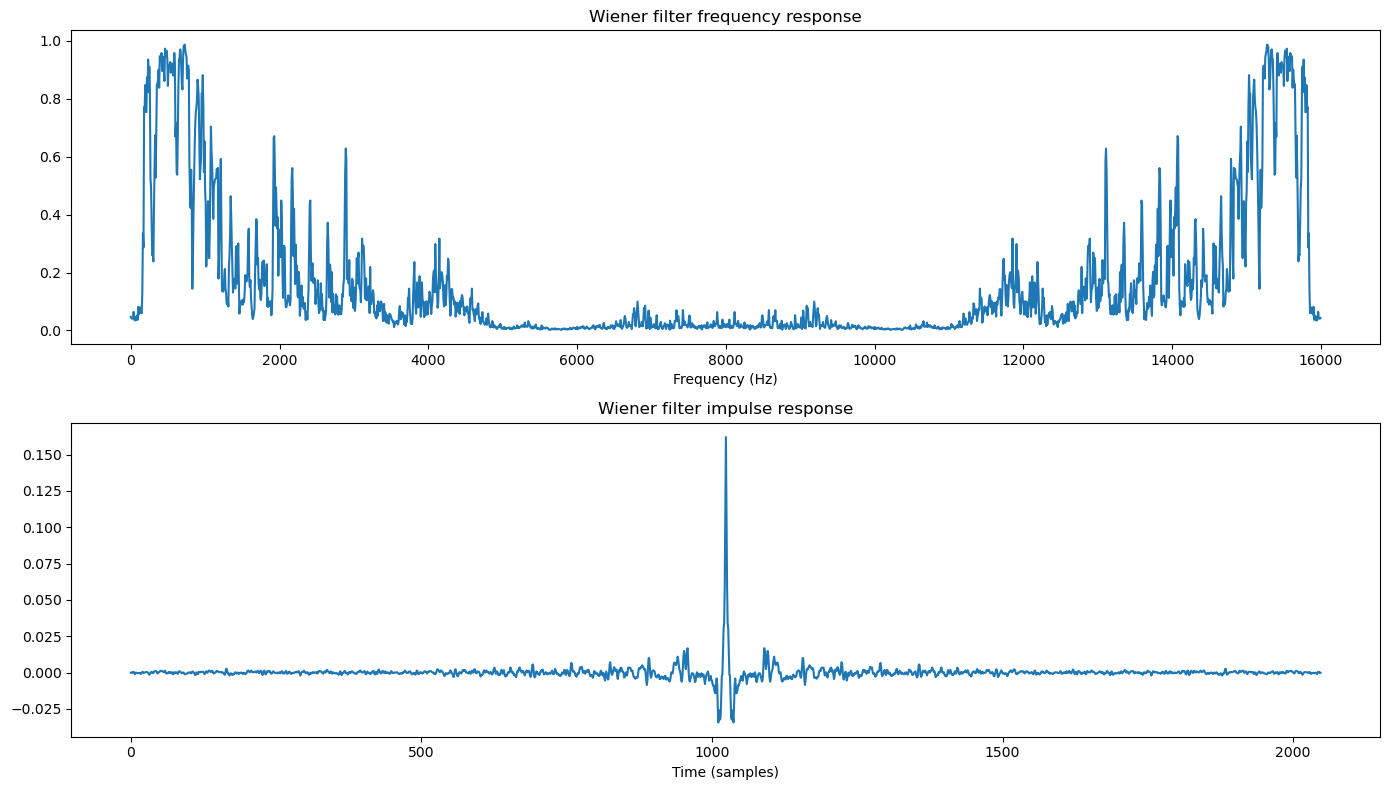

In [31]:
importlib.reload(extra)
H, h = extra.wiener_filter(Ssq,Vsq)

fig, ax = plt.subplots(2,1,figsize=(14,8))
ax[0].plot(frequency_axis,H)
ax[0].set_title('Wiener filter frequency response')
ax[0].set_xlabel('Frequency (Hz)')
ax[1].plot(h)
ax[1].set_title('Wiener filter impulse response')
ax[1].set_xlabel('Time (samples)')
fig.tight_layout()

In [32]:
importlib.reload(submitted)
M = len(h)+1
start_time = time.time()
y_overlap_add = submitted.overlap_add(h, noisy_speech, M)
end_time = time.time()
print('That took',end_time-start_time,'seconds')
IPython.display.Audio(data=y_overlap_add,rate=speech_rate)

That took 0.006409883499145508 seconds


That's it!  When you have everything working,

1. Test it on your machine by typing `python grade.py`
1. Upload `submitted.py` and `extra.py` to Gradescope!